In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
BATCH_SIZE =32
IMAGE_SIZE = 256
CHANNELS = 3 
dataset = tf.keras.preprocessing.image_dataset_from_directory('plantvillage',
                                                              batch_size=BATCH_SIZE,
                                                              image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                             shuffle=True)

Found 2152 files belonging to 3 classes.


In [3]:
def get_ds(ds,shuffle=True):
    if shuffle:
        ds = ds.shuffle(10000, seed = 12)
    ds_size = len(ds)
    train_split = 0.8
    val_split = 0.1

    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [4]:
train_ds, val_ds, test_ds = get_ds(dataset)
len(train_ds)

54

In [5]:
 class_names = dataset.class_names

In [6]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

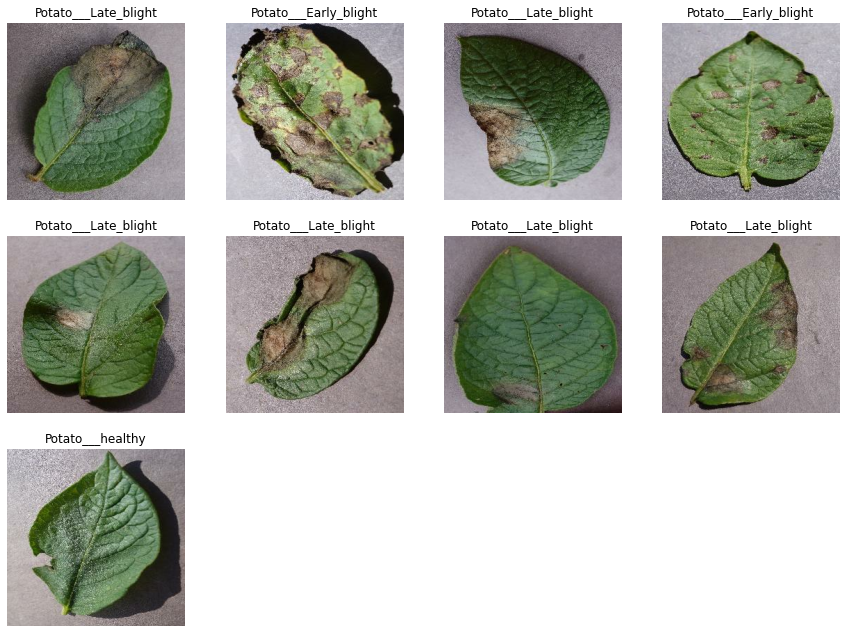

In [7]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax= plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
    

In [8]:
 EPOCHS=5

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)

54

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)
])

data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


In [12]:
input_shape =(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)


model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    
    
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape =(256,256)),
    layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', input_shape =(256,256)),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer ='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics =['accuracy']
)

In [16]:
model.fit(
    train_ds,
    epochs = 2,
    batch_size =BATCH_SIZE,
    verbose =1,
    validation_data=val_ds
)

Epoch 1/2
54/54 [==============================] - 313s 5s/step - loss: 1.3314 - accuracy: 0.7049 - val_loss: 0.5677 - val_accuracy: 0.8073
Epoch 2/2
54/54 [==============================] - 223s 4s/step - loss: 0.4418 - accuracy: 0.8397 - val_loss: 0.3918 - val_accuracy: 0.8542


In [17]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 19s 1s/step - loss: 0.3260 - accuracy: 0.8594


first image to predict
Actual label: Potato___Early_blight
1/1 [==============================] - 3s 3s/step
Predicted Label Potato___Late_blight


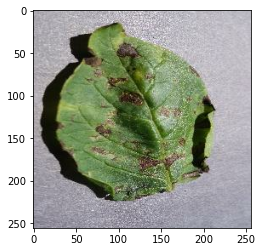

In [18]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('Actual label:',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])

In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 157ms/step


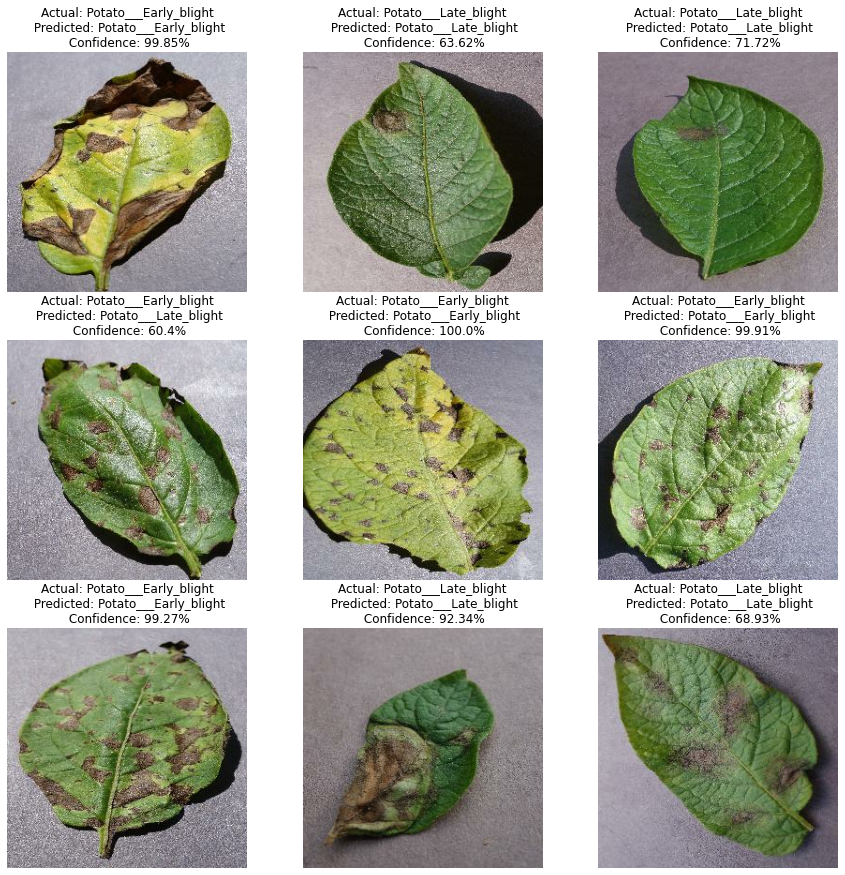

In [20]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3, i+1)
        plt.axis('off')
        plt.imshow(images[i].numpy().astype('uint8'))
        
        actual_class = class_names[labels[i]]
        predicted_class,confidence = predict(model, images[i].numpy())
        
       
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\n Confidence: {confidence}%")